### Load downsampled annotation file anre identify location

If the points has been transformed, load the output from Transformix
If ara2sample ran, just load the downsampled points itself

Associated each point with an atlas ID

Project downsampled points in to tiff file for illustration purposes (ie, can overlay to brain image stack or template stack)
- For axons only...since downsampled dendrites at 25um will just be a blob

Plot as a percentage of total axonal length

Plot as full resolution 3D scatter plot with hover region name

In [16]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import skimage
from skimage import io

import random

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
points_name=fdialog.askopenfile( title='Select the downsampled points(transformed if sample2ara, non-transformed if ara2sample)').name
ending_idx_name=fdialog.askopenfile( title='Select the ending indices corresponding to the point').name
atlas_name=fdialog.askopenfile( title='Select the corresponding atlas').name

outdir = fdialog.askdirectory(title='Please select the output directory')

atlas= sitk.ReadImage(atlas_name)

atlas.GetSize()

(563, 419, 360)

In [3]:
ending_indices = np.genfromtxt(ending_idx_name, delimiter=',', dtype='int')

In [4]:
# Load the csv file containing the labels
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

#Read the output points
output=open(points_name,'r')
outputpoint= output.readlines()

In [5]:
#Read the output points
output=open(points_name,'r')
outputpoint= output.readlines()

### The next 3 cells are only for points that are transformed(after sample2ara)

In [41]:
#This section is only for points that are transformed(after sample2ara)
key_word='OutputIndexFixed'
length=len(key_word)

all_points=[]
for lines in outputpoint:
    start= lines.find('OutputIndexFixed')
    this_line=lines[start+length+5:start+length+17] 
    this_line= this_line.split(' ')
    mypoints=[int(stuff) for stuff in this_line if stuff.isnumeric()]
    all_points.append(mypoints)

#this is a very stupid way of finding the output points
# note that we convert string into integer here

In [44]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id_inbrain=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,counts
0,1047,979.0,"Primary somatosensory area, barrel field, layer 4",SSp-bfd4,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1047/,188064,NaN,NaN,f,55,3439709501,734881840,Primary somatosensory area barrel field layer 4,2298
1,600,923.0,"Dorsal auditory area, layer 2/3",AUDd2/3,11,1,3,8690,1011.0,8,...,/997/8/567/688/695/315/247/1011/600/,019399,NaN,NaN,f,125,2148227545,734881840,Dorsal auditory area layer 2/3,2193
2,678,650.0,"Dorsal auditory area, layer 4",AUDd4,11,1,3,8690,1011.0,8,...,/997/8/567/688/695/315/247/1011/678/,019399,NaN,NaN,f,126,3650389730,734881840,Dorsal auditory area layer 4,873
3,873,1099.0,"Supplemental somatosensory area, layer 1",SSs1,11,1,3,8690,378.0,8,...,/997/8/567/688/695/315/453/378/873/,188064,NaN,NaN,f,102,697782769,734881840,Supplemental somatosensory area layer 1,2151
4,1038,978.0,"Primary somatosensory area, barrel field, laye...",SSp-bfd6a,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1038/,188064,NaN,NaN,f,57,2183435549,734881840,Primary somatosensory area barrel field layer 6a,1400


In [49]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

id_inatlas=[]
for x in atlas_labels['id']:
    intID = int(x)
    id_inatlas.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for id_inbrain in unique_id_inbrain:
    if id_inbrain not in id_inatlas:
        if id_inbrain==0:
            
            print(id_inbrain,'this index is outside of the brain, consider possible suboptimal image registration')
        else: 
            print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
        warnings.warn('Some points do not have corresponding labels')

182305696 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37
182305712 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Some points do not have corresponding labels


### The next cells are only for points that are not transformed (after ara2sample)

In [6]:
# This section is only for points that are not transformed (after ara2sample)
all_points=[]
for lines in outputpoint[2:]:
    this_line= lines.split (' ')
    mypoints= [int(stuff) for stuff in this_line]
    all_points.append(mypoints)

In [9]:
points_in_atlas=[int(atlas[i]) for i in all_points ]
#find an ID for all points

endings_in_atlas=[points_in_atlas[i] for i in ending_indices]
# find the IDs associated with endings

unique_id=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i), endings_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'Total_counts','Endings_counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

#our_regionWcounts.to_excel(outdir+'/RegionCounts.xlsx')

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,Total_counts,Endings_counts
0,1047,979.0,"Primary somatosensory area, barrel field, layer 4",SSp-bfd4,11,1,3,8690,329.0,9,...,188064,NaN,NaN,f,55,3439709501,734881840,Primary somatosensory area barrel field layer 4,9168,61
1,844,1095.0,"Primary motor area, Layer 6a",MOp6a,11,1,3,8690,985.0,8,...,1F9D5A,NaN,NaN,f,23,3473508879,734881840,Primary motor area Layer 6a,479,1
2,1085,1125.0,"Secondary motor area, layer 6b",MOs6b,11,1,3,8690,993.0,8,...,1F9D5A,NaN,NaN,f,30,1225271489,734881840,Secondary motor area layer 6b,18,0
3,945,1108.0,"Primary somatosensory area, upper limb, layer 6a",SSp-ul6a,11,1,3,8690,369.0,9,...,188064,NaN,NaN,f,85,2726127758,734881840,Primary somatosensory area upper limb layer 6a,1752,3
4,1086,984.0,"Primary somatosensory area, trunk, layer 4",SSp-tr4,11,1,3,8690,361.0,9,...,188064,NaN,NaN,f,90,1741439834,734881840,Primary somatosensory area trunk layer 4,27,0
5,1038,978.0,"Primary somatosensory area, barrel field, laye...",SSp-bfd6a,11,1,3,8690,329.0,9,...,188064,NaN,NaN,f,57,2183435549,734881840,Primary somatosensory area barrel field layer 6a,839,0
6,854,955.0,"Primary somatosensory area, upper limb, layer 2/3",SSp-ul2/3,11,1,3,8690,369.0,9,...,188064,NaN,NaN,f,82,243505027,734881840,Primary somatosensory area upper limb layer 2/3,2047,16
7,940,541.0,cingulum bundle,cing,8,1,3,8690,768.0,4,...,CCCCCC,NaN,NaN,f,1244,1622445056,734881840,cingulum bundle,896,3
8,577,1062.0,"Primary somatosensory area, upper limb, layer 4",SSp-ul4,11,1,3,8690,369.0,9,...,188064,NaN,NaN,f,83,4219333960,734881840,Primary somatosensory area upper limb layer 4,5121,34
9,1006,974.0,"Primary somatosensory area, trunk, layer 1",SSp-tr1,11,1,3,8690,361.0,9,...,188064,NaN,NaN,f,88,396802005,734881840,Primary somatosensory area trunk layer 1,1179,2


In [9]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

id_inatlas=[]
for x in atlas_labels['id']:
    intID = int(x)
    id_inatlas.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

num_of_zeros = [i for i, x in enumerate(points_in_atlas) if x == 0]
# find the indices for which carries an id =0

for id_inbrain in unique_id:
    if id_inbrain not in id_inatlas:
        if id_inbrain==0:
            print(f'There are {len(num_of_zeros)} points with ID= {id_inbrain}, this index is outside of the brain, consider possible suboptimal image registration')
        else: 
            print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
        warnings.warn('Some points do not have corresponding labels')

# Turns out these big numbers exist in atlas but have no name in the json file..ask on allen brain map community forum
# the 0 index is points out of the brain b/c registration problem

There are 504 points with ID= 0, this index is outside of the brain, consider possible suboptimal image registration


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Some points do not have corresponding labels


## Now the two methods converge, continue here

count the numberof points in each region andplot as a percentage

Save the points position as a tiff stack to later project to the brain

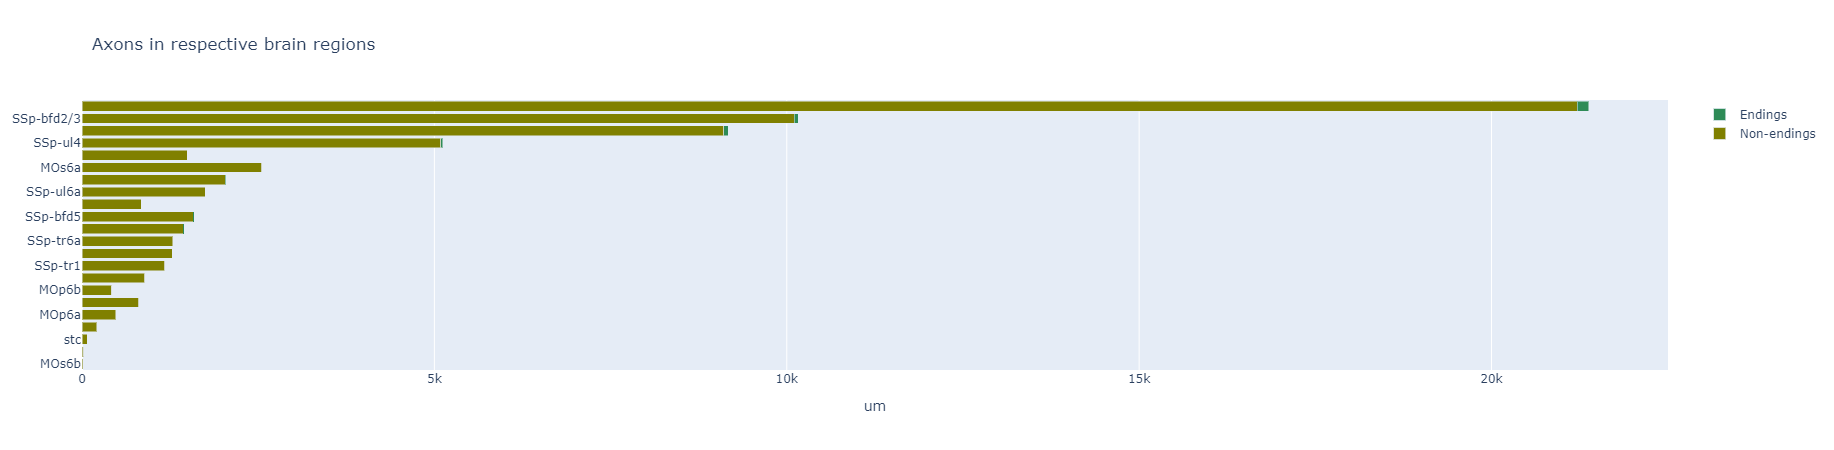

In [30]:
import plotly.offline
import plotly.graph_objects as go

y=our_regionWcounts['acronym']
fig = go.Figure()
fig.add_trace(go.Bar(
    y=y, x=our_regionWcounts['Total_counts']-our_regionWcounts['Endings_counts'], 
    name='Non-endings', marker_color='olive',
    hovertext=our_regionWcounts['name'],
    orientation='h')
             )
fig.add_trace(go.Bar(
    y=y, x=our_regionWcounts['Endings_counts'],
    name='Endings', marker_color='seagreen',
    orientation='h')
             )

fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'}, 
                  title='Axons in respective brain regions',
                  hovermode="y",
                  xaxis_title='um')
fig.show()
plotly.offline.plot(fig, filename=outdir+'/'+ outdir[3:8]+'BarPlot.html')

In [14]:
#Plot the result

our_regionWcounts=our_regionWcounts.sort_values(by=['Total_counts'])

percent=100*our_regionWcounts['Total_counts']/np.sum(our_regionWcounts['Total_counts'])

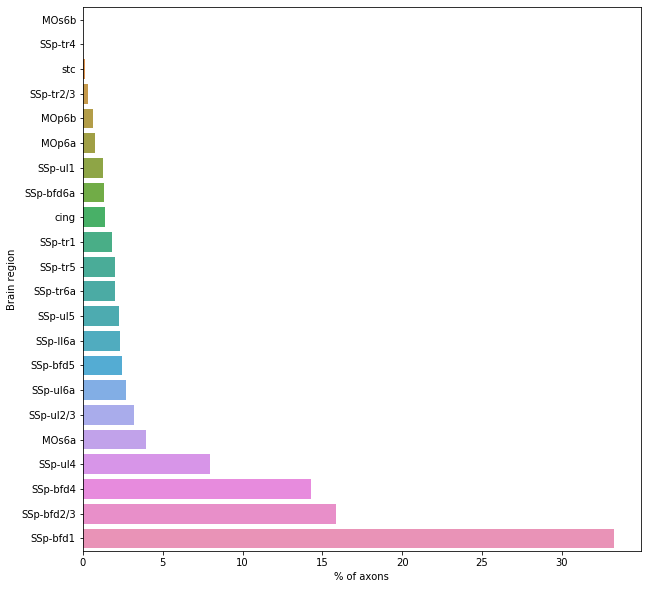

In [17]:
fig, ax = plt.subplots(figsize=[10,10])
my_plot=sns.barplot(y="acronym", x=percent, data=our_regionWcounts)
ax.set(xlabel='% of axons', ylabel='Brain region')
sns.set_context("talk")
sns.set_palette("pastel")
                
#fig.savefig(outdir+"/RegionPlot.svg")

In [21]:
# Now project downsampled points into tiff to see if they make sense
svolume=np.zeros(atlas.GetSize())
#columns, rows, planes

zplanes=[]
for i in all_points:
    zplanes.append( i[2])
zplanes=np.unique(zplanes)
print(zplanes)

[ 14  15  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  83  84  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197]


In [22]:
temp=np.zeros(atlas.GetSize()[0:2])
thepoints=np.asarray(all_points)

for i in zplanes:
    index= thepoints[:,2]==i
    uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
    for j, lines in enumerate(uindex):
        coord1,coord2=lines[0:2]
        temp[coord1][coord2]= counts[j]
    svolume[:,:,i]=temp #write this in 
    temp=np.zeros(atlas.GetSize()[0:2]) #reset the empty plane after each z

In [23]:
for j, lines in enumerate(uindex):
    coord1,coord2=lines[0:2]
    temp[coord1][coord2]= counts[j]

displaying plane 186


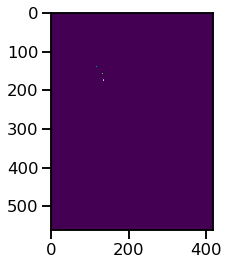

In [27]:
ztoshow=random.choice(zplanes)
plt.imshow(svolume[:,:,ztoshow])
print(f'displaying plane {ztoshow}' )

In [37]:
coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
#for some reason, if just save stuff as tiff, it will save x planes of yz view
#here we shift the 3rd dimension with the first dimension to obtain xy view
m=re.search('\D{2}[0-9]{3}[D]', name)

if m:
    out_name= outdir[3:]+ 'D_DSpoints.tif'
else:
    out_name= outdir[3:]+ '_DSpoints.tif'
print(outdir+'/'+ out_name)

io.imsave(outdir+'/'+ out_name,coronal_planetmp)

D:/AL126/AL126_DSpoints.tif


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/AL126/AL126_DSpoints.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


## Plots the non'downsampled points in 3d space

In [18]:
import plotly
import plotly.graph_objects as go
from plotly import __version__
print(__version__)


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

4.5.0


In [19]:
ori_points_name=fdialog.askopenfile( title='Select the converted&resampled origional points').name

#Load the origional points
anno=open(ori_points_name,'r')
anno_data=anno.readlines()
# heading is stored in anno_data[2], 1st line basically useless

headings=anno_data[2].rstrip('\n').replace(' ', '').split(',')
annotations=[lines.rstrip(' 0\n').split(' ') for lines in anno_data[3:]]
#slight modification on replacing and stripping due to the format of the resampled swc
annotation_df=pd.DataFrame(annotations, columns=headings)

annotation_df.head()

,#id,type,x,y,z,r,pid
0,1,3,4811.63,2360.22,3550.49,1,2
1,2,3,4812.59,2360.24,3550.77,1,3
2,3,3,4813.55,2360.27,3551.06,1,4
3,4,3,4814.49,2360.24,3551.37,1,5
4,5,3,4815.36,2360.01,3551.81,1,6


In [20]:
points_with_id= pd.DataFrame (zip(annotation_df['x'],annotation_df['y'], annotation_df['z'],points_in_atlas ), columns=['x', 'y','z', 'atlasID'])
points_with_id.to_csv (outdir+'/resamp_oripoints_withID.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
points_with_id.head(10)

,x,y,z,atlasID
0,4811.63,2360.22,3550.49,971
1,4812.59,2360.24,3550.77,971
2,4813.55,2360.27,3551.06,971
3,4814.49,2360.24,3551.37,971
4,4815.36,2360.01,3551.81,971
5,4816.23,2359.79,3552.25,971
6,4817.13,2359.73,3552.67,971
7,4818.03,2359.75,3553.1,971
8,4818.89,2360,3553.54,971
9,4819.75,2360.24,3553.99,971


In [21]:
len(points_with_id)
# this is the total length (in um) of the trace if the trace is resampled in 1um steps

102165

In [22]:
#Assign a colour to each unique atlas ID for plotting
#this is need because atlas IDs has very high values which is outside of the colour range
uniqueID=np.unique(points_with_id['atlasID'])
colour= np.linspace(1,np.size(uniqueID)+1, num=np.size(uniqueID),dtype='int')

colourdict=dict(zip(uniqueID,colour))

In [74]:
#colourdict=dict(zip(atlas_labels['id'], atlas_labels['color_hex_triplet']))
# cannot use the allen atlases colour because some are not recognized by plotly

In [23]:
namedict=dict(zip(atlas_labels['id'],atlas_labels['name']))
points_with_id['name'] = points_with_id['atlasID'].map(namedict)

points_with_id['colour'] = points_with_id['atlasID'].map(colourdict)
points_with_id.head()

,x,y,z,atlasID,name,colour
0,4811.63,2360.22,3550.49,971,"corpus callosum, posterior forceps",26
1,4812.59,2360.24,3550.77,971,"corpus callosum, posterior forceps",26
2,4813.55,2360.27,3551.06,971,"corpus callosum, posterior forceps",26
3,4814.49,2360.24,3551.37,971,"corpus callosum, posterior forceps",26
4,4815.36,2360.01,3551.81,971,"corpus callosum, posterior forceps",26


In [24]:
trace= go.Scatter3d( 
    x=points_with_id[::3]['x'],
    y=points_with_id[::3]['y'],
    z=points_with_id[::3]['z'],
    mode='markers',
    marker=dict(
        size=1,
        color=points_with_id[::3]['colour'],
        opacity=0.5),
    hovertext= points_with_id[::3]['name'],
    hoverinfo='text'
)

layout=go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0)
)

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
camera = dict(
    eye=dict(x=0, y=-1, z=0)
)


#Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
fig=go.Figure(data=trace,layout=layout)
fig.update_layout(scene_camera=camera, 
                  scene=dict(
                    xaxis_title='Smaller=more medial',
                    yaxis_title='Smaller=more dorsal',
                    zaxis_title='Smaller=more anterior'))
plot(fig,filename=outdir+'/'+ outdir[3:8]+'resampled3Dplot.html')

'D:/AL066/AL066resampled3Dplot.html'